In [35]:
%matplotlib inline

import os


import tensorflow_datasets as tfds
import tensorflow as tf
import cProfile
import time
import numpy as np
import matplotlib.pyplot as plt

<h1> Tensorflow eager exectuion needs to be enabled.<h1>

In [36]:
tf.compat.v1.enable_eager_execution()
tf.executing_eagerly()

True

<h1> 1. Load the data.<h1>  


Portuguese to English. Schooner does not have a common path for SSL certificate. Thus it is requested to download it mannually first. 

In [37]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True,download=False,data_dir="/home/adbadre/tensorflow_datasets/")
train_examples, val_examples = examples['train'], examples['validation']

<h1> 2. Tokenize the data.<h1>  

Transform words in machine readable format: My name is Adrien. ---> ['my', 'na','me','is','Adr','ien',"."] ---> [880,8522,2222,85,'8466','12','8521',0...,0]

In [38]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
     (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [39]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


In [40]:
for ts in tokenized_string:
    print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


In [41]:
tokenizer_en.vocab_size

8087

In [42]:
tokenizer_pt.vocab_size

8214

In [43]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [44]:
#Sentence With delimiters: Start and end
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
    return lang1, lang2

In [45]:
def tf_encode(pt, en):
    result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
    result_pt.set_shape([None])
    result_en.set_shape([None])

    return result_pt, result_en

In [46]:
#Max number of token to have a fix number of features. Fake ex: "Hello"-->[5,8,3,0,0,0...,0] and size 40
MAX_LENGTH = 40

In [47]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)


<h1> 3. Create datasets for learning.<h1>  

In [48]:

train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE,([None],[40]))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE,([None],[40]))

In [49]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: id=622986, shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: id=622987, shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

<h1> 4. Positional Encodding.<h1>  

Each token is embedded in a vector of size n. However, the networks needs a sense of 'position' for each token , since it matters here. Thus, a position encoding is added to each dimension of the vector 

In [50]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [51]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


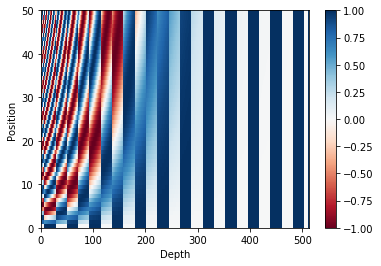

In [52]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

<h1> 5. Masking.<h1>  

This is the most important part of the transformer.Masks allows the network to 1) focus on the right part of the input tokens to train ---> padding mask 2) mask the part that need to be predicted during the training ---> look-ahead mask

In [53]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [54]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: id=623003, shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [55]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [56]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: id=623019, shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [57]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [61]:
enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

<h1> 6. Scaled Dot Product Attention and Multi Head Attention.<h1>  

This cell constains the code for the attention product among the heads in transformers. Each head contains depth=Encoding_size//num_heads_multi dimensions of encoding. It allows the model to compute more in parrallel.

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$


In [195]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  nb: depth=Encoding_size//num_heads_multi
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """
    #print("Coucou0:",q.shape)
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    print("Coucou1:",matmul_qk)
  # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk #/ tf.math.sqrt(dk)
    print(scaled_attention_logits.shape)
  # add the mask to the scaled tensor.
    if mask is not None:
        print(mask.shape)
        scaled_attention_logits += (mask * -1e9)  
        print(scaled_attention_logits.shape,scaled_attention_logits)
  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    #print("Coucou2:",attention_weights.shape)
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [196]:
512//8

64

In [197]:
 def split_heads( x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, 2, 10//2))
        return tf.transpose(x, perm=[0, 2, 1, 3])

In [198]:
def print_out(q, k, v,batch_size):
    q=split_heads( q, batch_size)
    k=split_heads( k, batch_size)
    v=split_heads( v, batch_size)
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(tf.random.uniform((2, 5)), tf.random.uniform((2,5)))
    temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, combined_mask)
    print ('Attention weights are:')
    print (temp_attn.shape)
    print ('Output is:')
    print (temp_out.shape)

In [199]:
y = tf.random.uniform((2, 5, 10))  # (batch_size, encoder_sequence, d_model)
print(y)
print_out(y,y,y,2)


tf.Tensor(
[[[0.68121254 0.59078825 0.25541353 0.25627518 0.33704412 0.48741806
   0.6281066  0.18117249 0.2691809  0.05804956]
  [0.15976095 0.8533579  0.7923213  0.4650135  0.6051909  0.47978926
   0.45342112 0.77171755 0.20534515 0.8935585 ]
  [0.52167416 0.6024835  0.8030534  0.8378202  0.49565768 0.3090304
   0.44577014 0.05659437 0.7606263  0.27020216]
  [0.6981547  0.53006005 0.22907174 0.16822374 0.30689967 0.65548456
   0.754681   0.00303864 0.8861331  0.2946664 ]
  [0.90246606 0.5658637  0.87575054 0.25133216 0.48162103 0.57957935
   0.87933445 0.5734854  0.32044983 0.55466735]]

 [[0.42803073 0.00203907 0.3585745  0.57353115 0.17774034 0.16188323
   0.6419151  0.5819484  0.40438747 0.60522735]
  [0.8858521  0.18687081 0.01288319 0.04826677 0.8481363  0.5129862
   0.9011798  0.86810064 0.64729214 0.7717999 ]
  [0.2905841  0.3933642  0.25136924 0.2158786  0.07070589 0.34938455
   0.339512   0.101354   0.13799798 0.1793909 ]
  [0.2239201  0.37771058 0.72612786 0.7802303  0.6245

In [110]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,0,10],
                      [0,10,0]
                      ], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0,5],
                      [  10,0,7],
                      [ 100,5,1]], dtype=tf.float32)  # (4, 2)

temp_q = tf.constant([[0, 10, 0],
                     [0, 0, 10],
                     [10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

(3, 3)
Attention weights are:
tf.Tensor(
[[0.  0.  1. ]
 [0.  1.  0. ]
 [0.5 0.  0.5]], shape=(3, 3), dtype=float32)
Output is:
tf.Tensor(
[[100.    5.    1. ]
 [ 10.    0.    7. ]
 [ 50.5   2.5   3. ]], shape=(3, 3), dtype=float32)


In [111]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

(1, 3)
Attention weights are:
tf.Tensor([[0. 1. 0.]], shape=(1, 3), dtype=float32)
Output is:
tf.Tensor([[10.  0.  7.]], shape=(1, 3), dtype=float32)


In [112]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

(1, 3)
Attention weights are:
tf.Tensor([[0.5 0.  0.5]], shape=(1, 3), dtype=float32)
Output is:
tf.Tensor([[50.5  2.5  3. ]], shape=(1, 3), dtype=float32)


In [113]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

(3, 3)
Attention weights are:
tf.Tensor(
[[0.  1.  0. ]
 [0.  0.  1. ]
 [0.5 0.  0.5]], shape=(3, 3), dtype=float32)
Output is:
tf.Tensor(
[[ 10.    0.    7. ]
 [100.    5.    1. ]
 [ 50.5   2.5   3. ]], shape=(3, 3), dtype=float32)


<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention. Dimension= (batch_size,number_of_heads,number_of_tokens,depth) 
*    Concatenation of heads.
*    Final linear layer.
*    $h=NumberOfHeads$
*    $depth = \frac{EmbeddingSize}{NumberOfHeads}$

In [114]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [115]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((32, 40, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(32, 8, 40, 40)


(TensorShape([Dimension(32), Dimension(40), Dimension(512)]),
 TensorShape([Dimension(32), Dimension(8), Dimension(40), Dimension(40)]))

Used to recombined the local results of dimensions

In [71]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [99]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((32, 40, 512))).shape

TensorShape([Dimension(32), Dimension(40), Dimension(512)])

<h1> 7. Encoder Layer <h1>  

Multihead ---> dropout ---> residual addition + layer normalization ----> point wise ffn ---> dropout ---> residual addition + layer normalization

In [73]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [74]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([Dimension(64), Dimension(43), Dimension(512)])

<h1> 8. Decoder Layer <h1>  

This layer encompasses the different modules needed to form a decoder layer. The call method, in addition of the output sentence appropriatly masked, needs the encoder output for key query values in the second attention block. 

In [75]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)


    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [76]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([Dimension(64), Dimension(50), Dimension(512)])

In [77]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [78]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


The two class are used to control the Decoder and Encoder modules. It is assumed that several Encoder layer and several decoder layers can be stacked.

In [79]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
           maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, 
       look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [80]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([Dimension(64), Dimension(26), Dimension(512)]),
 TensorShape([Dimension(64), Dimension(8), Dimension(26), Dimension(62)]))

<h1> 9. Full Transformer Module <h1>

This class just focus on creating the Transformer module.The call method return the output and the attention weights of interest.

In [81]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        
        return final_output, attention_weights

In [82]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([Dimension(64), Dimension(36), Dimension(8000)])

In [83]:
sample_transformer.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (Encoder)          multiple                  10656768  
_________________________________________________________________
decoder_1 (Decoder)          multiple                  12504064  
_________________________________________________________________
dense_86 (Dense)             multiple                  4104000   
Total params: 27,264,832
Trainable params: 27,264,832
Non-trainable params: 0
_________________________________________________________________


<h1> 10. Prepare model for training <h1>

<h2> 10.1 Parameters Specification <h2>

In [84]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

<h2> 10.2 Custom optimizer: Special learning rate with Adam <h2>

In [85]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [86]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

<h2> 10.3 Loss Function <h2>

This is done in two step: Computing the categorical cross antropy  and making sure that the netowrk doesn't care about masked prediction. 

In [87]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [88]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [89]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

<h2> 10.4 Create Model <h2>

In [90]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

<h2> 10.5 Create Masks <h2>

In [91]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [92]:
enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

<h2> 10.6 Create Checkpoints <h2>

In [93]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


<h2> 10.7 Create a training step function <h2>

In [94]:
EPOCHS = 20

In [95]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

        gradients = tape.gradient(loss, transformer.trainable_variables)    
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

        train_loss(loss)
        train_accuracy(tar_real, predictions)

<h2> 10.8 Train the model <h2>

In [96]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
              epoch + 1, batch, train_loss.result(), train_accuracy.result()))

        if (epoch + 1) % 5 == 0:
            ckpt_save_path = ckpt_manager.save()
            print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                                 ckpt_save_path))

    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Tensor("transformer_1/encoder_2/encoder_layer_5/multi_head_attention_16/add:0", shape=(?, 8, ?, ?), dtype=float32)
Tensor("transformer_1/encoder_2/encoder_layer_6/multi_head_attention_17/add:0", shape=(?, 8, ?, ?), dtype=float32)
Tensor("transformer_1/encoder_2/encoder_layer_7/multi_head_attention_18/add:0", shape=(?, 8, ?, ?), dtype=float32)
Tensor("transformer_1/encoder_2/encoder_layer_8/multi_head_attention_19/add:0", shape=(?, 8, ?, ?), dtype=float32)
Tensor("transformer_1/decoder_2/decoder_layer_5/multi_head_attention_20/add:0", shape=(?, 8, ?, ?), dtype=float32)


Exception ignored in: <bound method IteratorResourceDeleter.__del__ of <tensorflow.python.data.ops.iterator_ops.IteratorResourceDeleter object at 0x2b659856b2b0>>
Traceback (most recent call last):
  File "/home/adbadre/.local/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 531, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/home/adbadre/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 787, in delete_iterator
    deleter)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [92]:
epoch

19

<h1> 11. Evaluate and print results <h1>

In [88]:
def evaluate(inp_sentence):
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]
    
    # inp sentence is portuguese, hence adding the start and end token
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # as the target is english, the first word to the transformer should be the
    # english start token.
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if predicted_id == tokenizer_en.vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [89]:
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))

    sentence = tokenizer_pt.encode(sentence)

    attention = tf.squeeze(attention[layer], axis=0)

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result)-1.5, -0.5)

        ax.set_xticklabels(
            ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)

        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                            if i < tokenizer_en.vocab_size], 
                           fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head+1))

    plt.tight_layout()
    plt.show()

In [95]:
def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
    print(result)
    predicted_sentence = tokenizer_en.decode([i for i in result if i < tokenizer_en.vocab_size])  
    

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))

    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

tf.Tensor(
[8087   16   13    3  124  774   12 2224    1   12   98    3  124  774
   12 2224    2 8088    2 8088    2 8088    2 8088    2 8088    2 8088
 7863    6  161    2 8088    2 8088    2 8088    2 8088    2 8088], shape=(41,), dtype=int32)
Input: este é o primeiro livro que eu fiz.
Predicted translation: this is the first book i made , i did the first book i made . . . . . . of them . . . . .


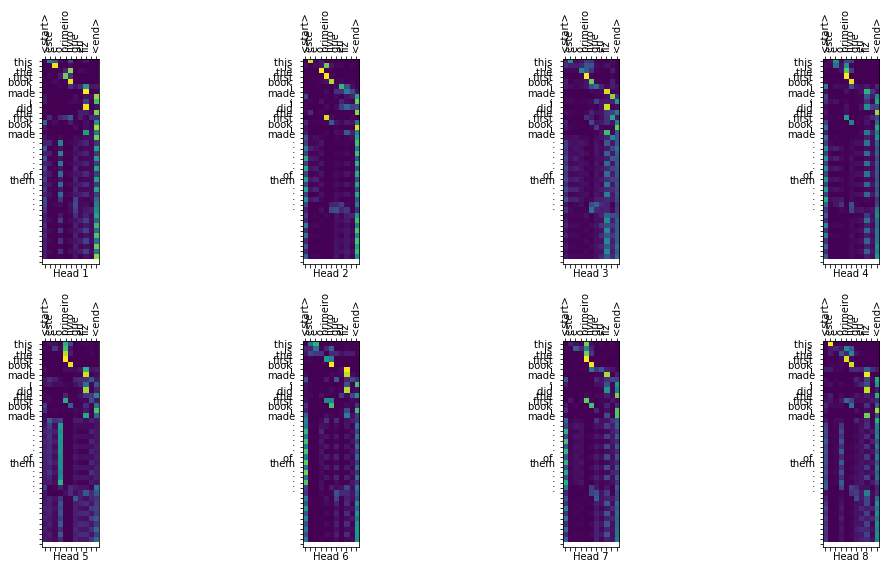

Real translation: this is the first book i've ever done.


In [96]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")